In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from typing import Union
import os
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

In [9]:
torch.cuda.is_available()

True

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DDPM
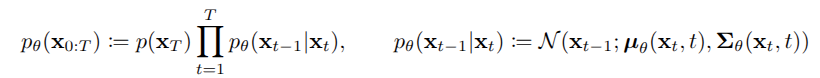
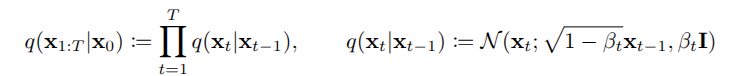
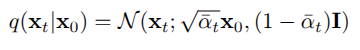
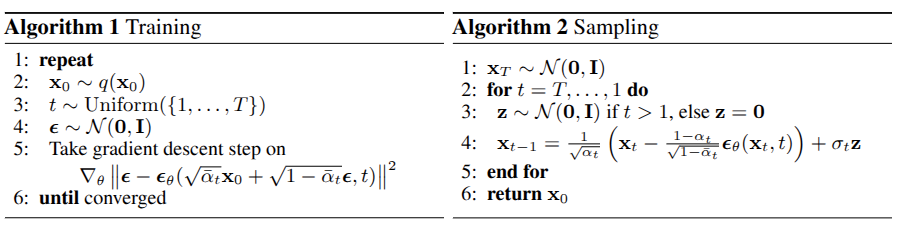

# TODO
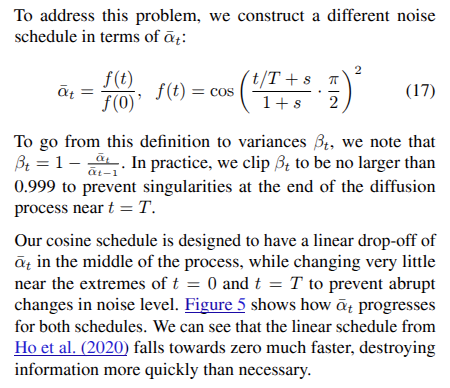

In [11]:
def gather(x: torch.Tensor, t: Union[int, torch.Tensor]):
    if isinstance(t, int):
        t = torch.tensor([t], dtype=torch.long, device=x.device)
    elif isinstance(t, list):
        t = torch.tensor(t, dtype=torch.long, device=x.device)
    elif isinstance(t, torch.Tensor):
        t = t.to(dtype=torch.long, device=x.device)
    else:
        raise ValueError("Unsupported type for t")

    temp = x.gather(0, t)
    return temp.reshape(-1, 1, 1, 1)


class DDPM:
    def __init__(self, model: nn.Module, device: torch.device, n_steps = 1000, beta_start = 1e-4, beta_end = 0.02):
        super().__init__()
        self.n_steps = n_steps
        self.model = model
        self.device = device

        self.betas = torch.linspace(beta_start, beta_end, n_steps).to(device)
        self.alphas = 1 - self.betas
        self.alpha_bar = torch.cumprod(self.alphas, dim=0)

    def q(self, x_0: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Compute the forward diffusion process q(x_t | x_{t-1}).
        """
        alpha_bar_t = gather(self.alpha_bar, t)
        mean = torch.sqrt(alpha_bar_t) * x_0
        var = 1. - gather(self.alpha_bar, t)
        return mean, var
    
    def q_sample(self, x_0, t, eps=None):
        """
        Sample from the forward diffusion process q(x_t | x_0).
        """
        if eps is None:
            eps = torch.randn_like(x_0)
        mean, var = self.q(x_0, t)
        return mean + torch.sqrt(var) * eps
    
    def p_sample(self, x_t, t):
        eps_theta = self.model(x_t, t)
        alpha_bar_t = gather(self.alpha_bar, t)
        alpha_t = gather(self.alphas, t)
        mean = (1. / torch.sqrt(alpha_t)) * (x_t - (1. - alpha_t) / torch.sqrt(1. - alpha_bar_t) * eps_theta)
        var = gather(self.betas, t)
        eps = torch.randn_like(x_t, device=self.device)
        return mean + torch.sqrt(var) * eps
    
    def loss(self, x_0, noise=None):
        """
        Compute the loss for the model.
        """
        if noise is None:
            noise = torch.randn_like(x_0)
        t = torch.randint(0, self.n_steps, (x_0.size(0),), device=self.device)
        x_t = self.q_sample(x_0, t, noise)
        eps_theta = self.model(x_t, t)
        return F.mse_loss(eps_theta, noise)
    
    def sample(self, n_samples=1, image_size=(1, 28, 28), xt=None):
        if xt is not None:
            x_t = xt.to(self.device)
        else:
            x_t = torch.randn(n_samples, *image_size).to(self.device)
        
        for t in reversed(range(self.n_steps)):
            t_batch = torch.full((n_samples,), t, device=self.device, dtype=torch.long)
            x_t = self.p_sample(x_t, t_batch)  # assumes p_sample does noise addition
        
        return torch.clamp(x_t, -1.0, 1.0)

# UNet
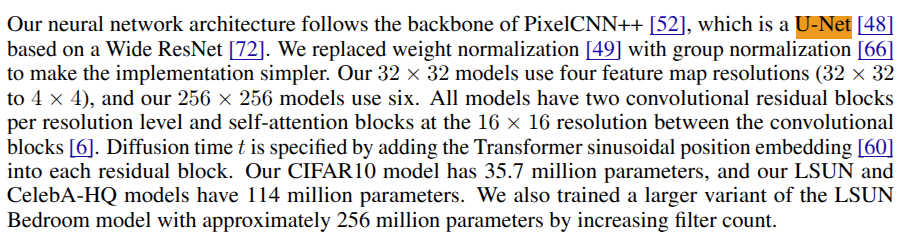
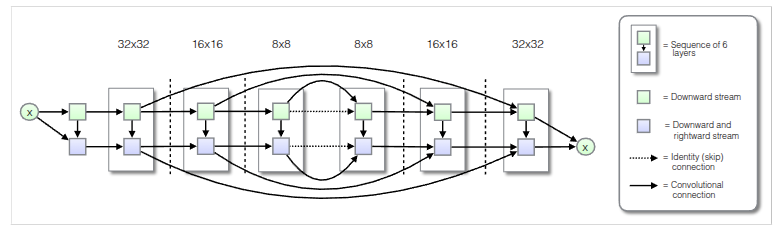

In [12]:
class SinusoidalPositionEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_dim, groups=8):
        super().__init__()
        self.group_norm1 = nn.GroupNorm(groups, in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.group_norm2 = nn.GroupNorm(groups, out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.time_emb = nn.Linear(time_dim, out_channels)
        self.residual_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()

    def forward(self, x, t):
        h = self.group_norm1(x)
        h = F.silu(h)
        h = self.conv1(h)
        h = self.group_norm2(h)
        h += self.time_emb(t)[:, :, None, None]
        h = F.silu(h)
        h = self.conv2(h)
        return h + self.residual_conv(x)

class SelfAttentionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.norm = nn.GroupNorm(8, channels)
        self.q = nn.Conv2d(channels, channels, 1)
        self.k = nn.Conv2d(channels, channels, 1)
        self.v = nn.Conv2d(channels, channels, 1)
        self.proj_out = nn.Conv2d(channels, channels, 1)

    def forward(self, x):
        B, C, H, W = x.shape
        h = self.norm(x)
        q = self.q(h).view(B, C, -1).permute(0, 2, 1)
        k = self.k(h).view(B, C, -1)
        v = self.v(h).view(B, C, -1)
        
        attn = torch.bmm(q, k) * (C ** -0.5)
        attn = F.softmax(attn, dim=-1)
        
        out = torch.bmm(v, attn.permute(0, 2, 1))
        out = out.view(B, C, H, W)
        return x + self.proj_out(out)

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, base_channels=32, time_dim=128):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbedding(time_dim),
            nn.Linear(time_dim, time_dim * 4),
            nn.SiLU(),
            nn.Linear(time_dim * 4, time_dim)
        )

        # Downsampling
        self.down1 = nn.ModuleList([
            ResidualBlock(in_channels, base_channels, time_dim, groups=1),
            ResidualBlock(base_channels, base_channels, time_dim)
        ])
        self.down2 = nn.ModuleList([
            ResidualBlock(base_channels, base_channels*2, time_dim),
            SelfAttentionBlock(base_channels*2),
            ResidualBlock(base_channels*2, base_channels*2, time_dim)
        ])
        
        # Middle
        self.mid = nn.ModuleList([
            ResidualBlock(base_channels*2, base_channels*4, time_dim),
            SelfAttentionBlock(base_channels*4),
            ResidualBlock(base_channels*4, base_channels*2, time_dim)
        ])
        
        # Upsampling
        self.up2 = nn.ModuleList([
            ResidualBlock(base_channels*4, base_channels*2, time_dim),
            SelfAttentionBlock(base_channels*2),
            ResidualBlock(base_channels*2, base_channels, time_dim)
        ])
        self.up1 = nn.ModuleList([
            ResidualBlock(base_channels*2, base_channels, time_dim),
            ResidualBlock(base_channels, base_channels, time_dim)
        ])
        
        self.final_conv = nn.Conv2d(base_channels, out_channels, 3, padding=1)
        
        self.downsample = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x, t):
        t = self.time_mlp(t)
        x1 = []
        
        # Downsample path
        # Block 1 (28x28 -> 28x28)
        for block in self.down1:
            x = block(x, t)
        x1.append(x)
        x = self.downsample(x)  # 14x14
        
        # Block 2 (14x14 -> 14x14)
        for block in self.down2:
            if isinstance(block, SelfAttentionBlock):
                x = block(x)
            else:
                x = block(x, t)
        x1.append(x)
        x = self.downsample(x)  # 7x7
        
        # Middle (7x7 -> 7x7)
        for block in self.mid:
            if isinstance(block, SelfAttentionBlock):
                x = block(x)
            else:
                x = block(x, t)
        
        # Upsample path
        # Block 2 (7x7 -> 14x14)
        x = self.upsample(x)
        x = torch.cat([x, x1.pop()], dim=1)
        for block in self.up2:
            if isinstance(block, SelfAttentionBlock):
                x = block(x)
            else:
                x = block(x, t)
        
        # Block 1 (14x14 -> 28x28)
        x = self.upsample(x)
        x = torch.cat([x, x1.pop()], dim=1)
        for block in self.up1:
            x = block(x, t)
        
        return self.final_conv(x)



# model = UNet()
# x = torch.randn(8, 1, 28, 28)  # MNIST batch
# t = torch.randint(0, 1000, (8,))  # Random timesteps
# output = model(x, t)
# print(output.shape)  # Should be (8, 1, 28, 28)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0013971329..1.005154].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.33318597..1.3631518].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.73014224..1.536823].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1628058..2.2065995].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.192499..2.372642].


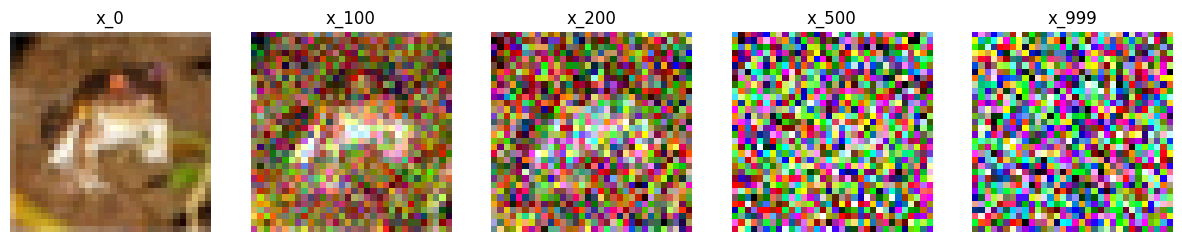

In [13]:
# Training Configuration
config = {
    'batch_size': 128,
    'epochs': 50,
    'lr': 2e-4,
    'n_steps': 1000,
    'weight_decay': 1e-5,
    'max_grad_norm': 1.0,
    'save_interval': 50,
}

# Data Preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=4, pin_memory=True)

# Model Initialization
model = UNet(in_channels=3, out_channels=3, base_channels=64).to(device)
diffusion = DDPM(model, device, n_steps=config['n_steps'])
optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['epochs'])

img, _ = train_dataset[0]  # Get a transformed CelebA image
sampled_image = img.unsqueeze(0).to(device)  # Add batch dimension

timesteps = [0, 100, 200, 500, 999]
sampled_images = []

for t in timesteps:
    x_t = diffusion.q_sample(sampled_image, t=torch.tensor([t]).to(device))
    img = x_t.squeeze(0).cpu().permute(1, 2, 0) * 0.5 + 0.5  # Denormalize to [0,1]
    sampled_images.append(img)

# Plotting (adjust for RGB)
plt.figure(figsize=(15, 3))
for i, (t, img) in enumerate(zip(timesteps, sampled_images)):
    plt.subplot(1, len(timesteps), i + 1)
    plt.imshow(img)
    plt.title(f"x_{t}")
    plt.axis('off')
plt.show()


Epoch 1/50: 100%|██████████| 391/391 [00:09<00:00, 43.17it/s, Loss=0.0740]


Epoch 1 | Avg Loss: 0.0926


Epoch 2/50: 100%|██████████| 391/391 [00:08<00:00, 43.64it/s, Loss=0.0358]


Epoch 2 | Avg Loss: 0.0426


Epoch 3/50: 100%|██████████| 391/391 [00:08<00:00, 44.95it/s, Loss=0.0431]


Epoch 3 | Avg Loss: 0.0399


Epoch 4/50: 100%|██████████| 391/391 [00:08<00:00, 44.84it/s, Loss=0.0425]


Epoch 4 | Avg Loss: 0.0384


Epoch 5/50: 100%|██████████| 391/391 [00:08<00:00, 44.93it/s, Loss=0.0214]


Epoch 5 | Avg Loss: 0.0367


Epoch 6/50: 100%|██████████| 391/391 [00:08<00:00, 44.83it/s, Loss=0.0230]


Epoch 6 | Avg Loss: 0.0358


Epoch 7/50: 100%|██████████| 391/391 [00:08<00:00, 44.86it/s, Loss=0.0319]


Epoch 7 | Avg Loss: 0.0349


Epoch 8/50: 100%|██████████| 391/391 [00:08<00:00, 44.90it/s, Loss=0.0357]


Epoch 8 | Avg Loss: 0.0355


Epoch 9/50: 100%|██████████| 391/391 [00:08<00:00, 44.75it/s, Loss=0.0375]


Epoch 9 | Avg Loss: 0.0342


Epoch 10/50: 100%|██████████| 391/391 [00:08<00:00, 44.82it/s, Loss=0.0228]


Epoch 10 | Avg Loss: 0.0339


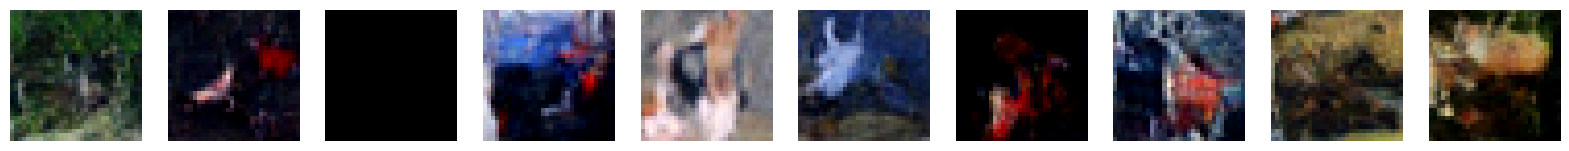

Epoch 11/50: 100%|██████████| 391/391 [00:09<00:00, 43.10it/s, Loss=0.0284]


Epoch 11 | Avg Loss: 0.0334


Epoch 12/50: 100%|██████████| 391/391 [00:09<00:00, 43.23it/s, Loss=0.0208]


Epoch 12 | Avg Loss: 0.0338


Epoch 13/50: 100%|██████████| 391/391 [00:09<00:00, 43.19it/s, Loss=0.0198]


Epoch 13 | Avg Loss: 0.0337


Epoch 14/50: 100%|██████████| 391/391 [00:09<00:00, 43.40it/s, Loss=0.0365]


Epoch 14 | Avg Loss: 0.0332


Epoch 15/50: 100%|██████████| 391/391 [00:09<00:00, 43.39it/s, Loss=0.0214]


Epoch 15 | Avg Loss: 0.0329


Epoch 16/50: 100%|██████████| 391/391 [00:09<00:00, 43.22it/s, Loss=0.0302]


Epoch 16 | Avg Loss: 0.0332


Epoch 17/50: 100%|██████████| 391/391 [00:09<00:00, 43.21it/s, Loss=0.0319]


Epoch 17 | Avg Loss: 0.0327


Epoch 18/50: 100%|██████████| 391/391 [00:09<00:00, 43.22it/s, Loss=0.0390]


Epoch 18 | Avg Loss: 0.0326


Epoch 19/50: 100%|██████████| 391/391 [00:09<00:00, 43.10it/s, Loss=0.0350]


Epoch 19 | Avg Loss: 0.0325


Epoch 20/50: 100%|██████████| 391/391 [00:09<00:00, 43.24it/s, Loss=0.0651]


Epoch 20 | Avg Loss: 0.0326


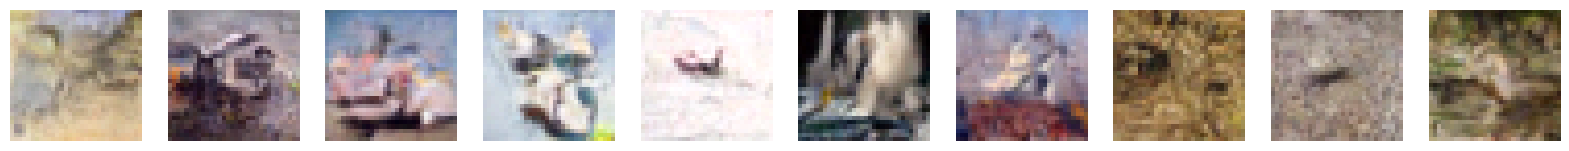

Epoch 21/50: 100%|██████████| 391/391 [00:09<00:00, 42.40it/s, Loss=0.0335]


Epoch 21 | Avg Loss: 0.0325


Epoch 22/50: 100%|██████████| 391/391 [00:09<00:00, 43.00it/s, Loss=0.0392]


Epoch 22 | Avg Loss: 0.0324


Epoch 23/50: 100%|██████████| 391/391 [00:09<00:00, 43.07it/s, Loss=0.0293]


Epoch 23 | Avg Loss: 0.0316


Epoch 24/50: 100%|██████████| 391/391 [00:09<00:00, 43.24it/s, Loss=0.0478]


Epoch 24 | Avg Loss: 0.0320


Epoch 25/50: 100%|██████████| 391/391 [00:09<00:00, 43.14it/s, Loss=0.0336]


Epoch 25 | Avg Loss: 0.0319


Epoch 26/50: 100%|██████████| 391/391 [00:09<00:00, 43.17it/s, Loss=0.0297]


Epoch 26 | Avg Loss: 0.0322


Epoch 27/50: 100%|██████████| 391/391 [00:09<00:00, 43.06it/s, Loss=0.0399]


Epoch 27 | Avg Loss: 0.0321


Epoch 28/50: 100%|██████████| 391/391 [00:09<00:00, 43.06it/s, Loss=0.0327]


Epoch 28 | Avg Loss: 0.0318


Epoch 29/50: 100%|██████████| 391/391 [00:09<00:00, 43.04it/s, Loss=0.0276]


Epoch 29 | Avg Loss: 0.0320


Epoch 30/50: 100%|██████████| 391/391 [00:09<00:00, 43.03it/s, Loss=0.0328]


Epoch 30 | Avg Loss: 0.0321


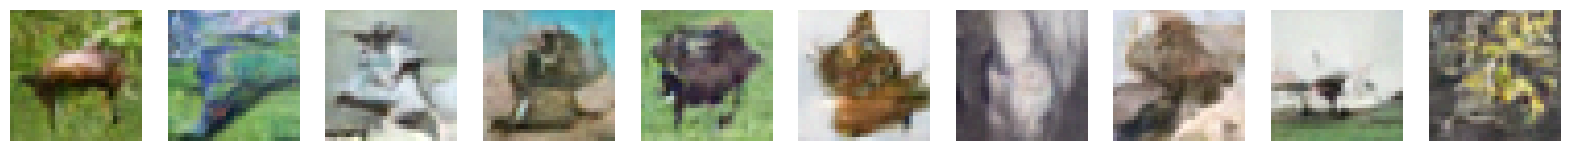

Epoch 31/50: 100%|██████████| 391/391 [00:09<00:00, 42.42it/s, Loss=0.0416]


Epoch 31 | Avg Loss: 0.0319


Epoch 32/50: 100%|██████████| 391/391 [00:09<00:00, 42.42it/s, Loss=0.0305]


Epoch 32 | Avg Loss: 0.0310


Epoch 33/50: 100%|██████████| 391/391 [00:09<00:00, 42.46it/s, Loss=0.0303]


Epoch 33 | Avg Loss: 0.0313


Epoch 34/50: 100%|██████████| 391/391 [00:09<00:00, 42.63it/s, Loss=0.0188]


Epoch 34 | Avg Loss: 0.0316


Epoch 35/50: 100%|██████████| 391/391 [00:09<00:00, 42.03it/s, Loss=0.0450]


Epoch 35 | Avg Loss: 0.0318


Epoch 36/50: 100%|██████████| 391/391 [00:09<00:00, 42.65it/s, Loss=0.0311]


Epoch 36 | Avg Loss: 0.0311


Epoch 37/50: 100%|██████████| 391/391 [00:09<00:00, 42.61it/s, Loss=0.0249]


Epoch 37 | Avg Loss: 0.0311


Epoch 38/50: 100%|██████████| 391/391 [00:09<00:00, 42.45it/s, Loss=0.0170]


Epoch 38 | Avg Loss: 0.0315


Epoch 39/50: 100%|██████████| 391/391 [00:09<00:00, 42.51it/s, Loss=0.0327]


Epoch 39 | Avg Loss: 0.0315


Epoch 40/50: 100%|██████████| 391/391 [00:09<00:00, 42.14it/s, Loss=0.0428]


Epoch 40 | Avg Loss: 0.0316


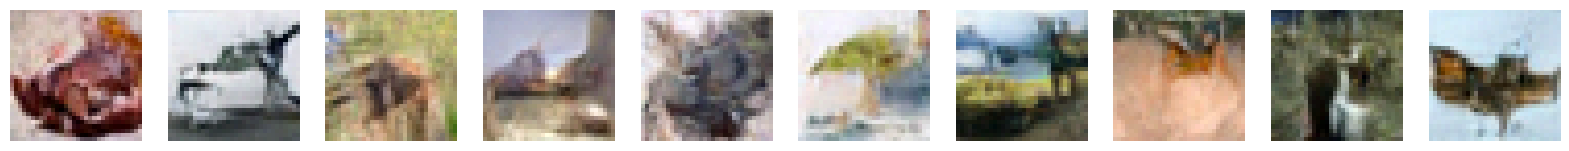

Epoch 41/50: 100%|██████████| 391/391 [00:09<00:00, 42.14it/s, Loss=0.0362]


Epoch 41 | Avg Loss: 0.0313


Epoch 42/50: 100%|██████████| 391/391 [00:09<00:00, 42.27it/s, Loss=0.0230]


Epoch 42 | Avg Loss: 0.0306


Epoch 43/50: 100%|██████████| 391/391 [00:09<00:00, 42.40it/s, Loss=0.0351]


Epoch 43 | Avg Loss: 0.0311


Epoch 44/50: 100%|██████████| 391/391 [00:09<00:00, 42.42it/s, Loss=0.0317]


Epoch 44 | Avg Loss: 0.0318


Epoch 45/50: 100%|██████████| 391/391 [00:09<00:00, 42.39it/s, Loss=0.0174]


Epoch 45 | Avg Loss: 0.0311


Epoch 46/50: 100%|██████████| 391/391 [00:09<00:00, 42.55it/s, Loss=0.0270]


Epoch 46 | Avg Loss: 0.0316


Epoch 47/50: 100%|██████████| 391/391 [00:09<00:00, 42.36it/s, Loss=0.0284]


Epoch 47 | Avg Loss: 0.0314


Epoch 48/50: 100%|██████████| 391/391 [00:09<00:00, 42.22it/s, Loss=0.0212]


Epoch 48 | Avg Loss: 0.0316


Epoch 49/50: 100%|██████████| 391/391 [00:09<00:00, 42.00it/s, Loss=0.0209]


Epoch 49 | Avg Loss: 0.0309


Epoch 50/50: 100%|██████████| 391/391 [00:09<00:00, 42.35it/s, Loss=0.0333]


Epoch 50 | Avg Loss: 0.0312


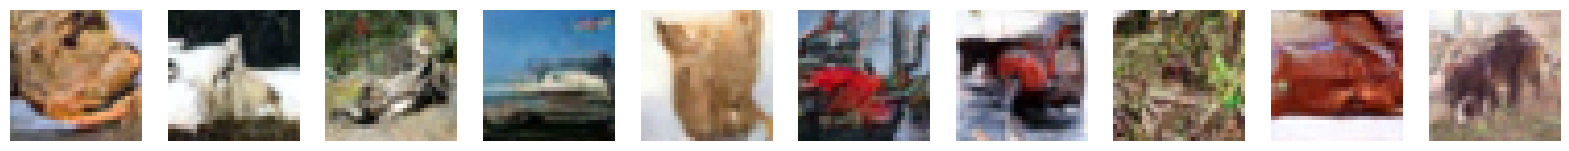

Training completed!


In [14]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=4, pin_memory=True)
best_loss = float('inf')
for epoch in range(config['epochs']):
    model.train()
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{config['epochs']}")
    total_loss = 0

    for images, _ in pbar:
        images = images.to(device)
        optimizer.zero_grad()
        loss = diffusion.loss(images)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), config['max_grad_norm'])
        optimizer.step()
        total_loss += loss.item()
        pbar.set_postfix({"Loss": f"{loss.item():.4f}"})

    scheduler.step()
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1} | Avg Loss: {avg_loss:.4f}")

    # Sampling and Saving
    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            sampled_images = diffusion.sample(n_samples=10, image_size=(3, 32, 32))
            sampled_images = torch.clamp(sampled_images, -1.0, 1.0)
            plt.figure(figsize=(20, 4))
            for i in range(10):
                plt.subplot(1, 10, i+1)
                img = sampled_images[i].cpu().permute(1, 2, 0).numpy()
                img = (img * 0.5 + 0.5).clip(0, 1)
                plt.imshow(img)
                plt.axis('off')
            plt.show()

    if (epoch + 1) % config['save_interval'] == 0:
        torch.save(model.state_dict(), f"checkpoints/ddpm_cifar10_epoch{epoch+1}.pth")

torch.save(model.state_dict(), "ddpm_cifar10_final.pth")
print("Training completed!")
